# Python GI Data (pygidata) — Usage Guide

Purpose: demonstrate core functionality of `GIDataClient` with short, runnable examples. It provides a python interface for Gantner' GI data platforms (Q.station, Q.core, GI.bench, GI.cloud).
Configure targets via environment variables; avoid hardcoding secrets.

## Prerequisites
- Python 3.10+
- Access to one or more GI targets (Q.station/Q.core/GI.bench or GI.cloud)
- Valid credentials or access token in environment variables

### Environment variables (override defaults as needed)
- `GI_QCORE_BASE` (default: `http://qcore-111003:8090`)
- `GI_QCORE_USER`, `GI_QCORE_PASS` (default: `admin`/`admin`)
- `GI_QSTATION_BASE` (default: `http://10.1.50.36:8090`)
- `GI_QSTATION_USER`, `GI_QSTATION_PASS`
- `GI_BENCH_BASE` (default: `http://127.0.0.1:8090`)
- `GI_BENCH_USER`, `GI_BENCH_PASS`
- `GI_CLOUD_BASE` (default: `https://demo.gi-cloud.io`)
- `GI_CLOUD_TOKEN`

---

**Note**

This notebook focuses on illustrating basic usage and integration patterns.
Not all function parameters are shown in the examples — most functions accept additional optional arguments for advanced configurations.
Use your IDE’s IntelliSense/autocompletion or Python’s built-in tools like help() and inspect.signature() to explore full parameter lists and defaults.

## 0) Setup (optional)
Uncomment and Install the library if not already available.


In [ ]:
# %pip install pygidata

Enable autoreload for debugging the library in notebooks.

In [ ]:
#%load_ext autoreload
#%autoreload 2

## 1) Imports & helpers
Minimal imports, logging, and event loop patching for notebooks.

In [1]:
from __future__ import annotations
import os, logging
from io import BytesIO
from typing import List
from uuid import UUID

import pandas as pd

from gi_data.dataclient import GIDataClient
from gi_data.mapping.enums import DataFormat, Resolution
from gi_data.mapping.models import VarSelector, CSVImportSettingsDefaultCloud
from gi_data.utils.logging import setup_module_logger

logger = setup_module_logger(__name__, level=logging.INFO)

## 2) Configuration and client factory
Select a profile and create a client. Uses environment variables when present.

In [2]:
PROFILES = {
    "qcore": {
        "base": os.getenv("GI_QCORE_BASE", "http://qcore-111003:8090"),
        "auth": {"username": os.getenv("GI_QCORE_USER", "admin"),
                 "password": os.getenv("GI_QCORE_PASS", "admin")},
    },
    "qstation": {
        "base": os.getenv("GI_QSTATION_BASE", "http://10.1.50.36:8090"),
        "auth": {"username": os.getenv("GI_QSTATION_USER", "admin"),
                 "password": os.getenv("GI_QSTATION_PASS", "admin")},
    },
    "bench": {
        "base": os.getenv("GI_BENCH_BASE", "http://127.0.0.1:8090"),
        "auth": {"username": os.getenv("GI_BENCH_USER", "admin"),
                 "password": os.getenv("GI_BENCH_PASS", "admin")},
    },
    "cloud": {
        "base": os.getenv("GI_CLOUD_BASE", "https://demo.gi-cloud.io"),
        "auth": {"access_token": os.getenv("GI_CLOUD_TOKEN", "9a430f6c-5bd1-473d-9a78-a1ec93796540")},
    },
}

ACTIVE_PROFILE = os.getenv("GI_PROFILE", "cloud")


def get_client(profile: str = ACTIVE_PROFILE) -> GIDataClient:
    cfg = PROFILES[profile]
    if cfg["auth"].get("access_token"):
        return GIDataClient(cfg["base"], access_token=cfg["auth"]["access_token"])
    return GIDataClient(cfg["base"],
                        username=cfg["auth"].get("username"),
                        password=cfg["auth"].get("password"))


client = get_client()

# Set log level for the client outputs
# Note: Set log level to debug for detailed request/response info from the backend
client.set_log_level(logging.INFO)  # INFO, DEBUG, WARNING, ERROR

In [3]:
from pprint import pprint

sources = client.list_buffer_sources()
pprint(sources)
client.list_buffer_variables(sources[0].id)


2025-11-12 15:33:49,216 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 6868
2025-11-12 15:33:49,249 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 4086


[GIStream(name='PythonImportedStream', id='11111111-2222-3333-4444-555555555511', sample_rate_hz=1.0, first_ts=1762955400000.0, last_ts=1762956480000.0, index=0),
 GIStream(name='ImportTestStreamCSV2', id='11111111-2222-3333-4444-555555555514', sample_rate_hz=0.016666666666666666, first_ts=1762780020000.0, last_ts=1762780920000.0, index=1),
 GIStream(name='OTF4_CMS_Skimmer', id='2d5cfdc8-0ef4-11ec-b094-02420a0001be', sample_rate_hz=10.0, first_ts=1630920600000.0, last_ts=1762957860000.0, index=2),
 GIStream(name='OTF4_CMS_Live_New', id='708d5f80-509b-11e9-8bd7-02420a000a33', sample_rate_hz=100.0, first_ts=1714778220000.0, last_ts=1762957920000.0, index=3),
 GIStream(name='OTF4_Nemione_Add_100Hz_RT1y', id='951af376-76f5-11f0-9037-02420a00019e', sample_rate_hz=100.0, first_ts=1754957580000.0, last_ts=1762859100000.0, index=4),
 GIStream(name='OTF4_Nemione_Add_1m', id='9d8ed806-76f5-11f0-8230-02420a00019e', sample_rate_hz=0.016666666666944444, first_ts=1754957580000.0, last_ts=17599484400

[GIStreamVariable(id='59b8ac13-6b2e-4509-97bc-bf329b55bdd1', name='Tcontainer', gql_id='a7', index=0, unit='°C', data_type='FLOAT', sid='11111111-2222-3333-4444-555555555511'),
 GIStreamVariable(id='74ad7c1c-45ee-4a27-a749-5f1b830e9ea0', name='Tamb', gql_id='a10', index=1, unit='°C', data_type='FLOAT', sid='11111111-2222-3333-4444-555555555511'),
 GIStreamVariable(id='86853dbf-9c04-413e-a46e-6eaf67fc41da', name='Gh', gql_id='a12', index=2, unit='W/m2', data_type='FLOAT', sid='11111111-2222-3333-4444-555555555511'),
 GIStreamVariable(id='4b3e5c65-03fc-4970-85aa-d3f1fc6b3493', name='Spare_01', gql_id='a4', index=3, unit='°C', data_type='FLOAT', sid='11111111-2222-3333-4444-555555555511'),
 GIStreamVariable(id='00d85abd-b854-4058-a6ba-58206b357ff7', name='Acc_x', gql_id='a0', index=4, unit='g', data_type='FLOAT', sid='11111111-2222-3333-4444-555555555511'),
 GIStreamVariable(id='c01ae5f5-49b5-440d-831a-4c9a46102e9d', name='Acc_y', gql_id='a13', index=5, unit='g', data_type='FLOAT', sid='1

## 3) Online — list, read, optional write
Read a few variables. If an output variable named `SP_1` exists, write a test value.

In [4]:
vars_ = client.list_variables()
assert vars_, "no online variables"
vids = [v for v in vars_[:10]]

# Read the live data of the first 10 variables 10 times in a row
for i in range(10):
    values = client.read_online([v.id for v in vids])
    print(f"Read {i + 1}: {values}")

2025-11-12 15:33:53,783 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 16179
2025-11-12 15:33:53,815 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146
2025-11-12 15:33:53,849 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146
2025-11-12 15:33:53,879 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146
2025-11-12 15:33:53,910 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146
2025-11-12 15:33:53,946 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146
2025-11-12 15:33:53,979 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146
2025-11-12 15:33:54,010 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146


Read 1: {UUID('bddcdc2c-0d2b-11eb-9b6d-02420a000a54'): 816273234000000.0, UUID('c01486f4-11d9-11eb-a636-02420a000aa7'): 2, UUID('c015ae76-11d9-11eb-805b-02420a000aa7'): 704, UUID('c024b5ce-11d9-11eb-8878-02420a000aa7'): 4071, UUID('c02615ae-11d9-11eb-8800-02420a000aa7'): 25, UUID('c038938c-11d9-11eb-bc1c-02420a000aa7'): 0.61, UUID('c039b960-11d9-11eb-97dc-02420a000aa7'): 13, UUID('65b490f4-11da-11eb-824c-02420a000aa7'): 457.954, UUID('65b5fb38-11da-11eb-82b0-02420a000aa7'): 0.007, UUID('8dfe482a-11da-11eb-a5b9-02420a000aa7'): 0}
Read 2: {UUID('bddcdc2c-0d2b-11eb-9b6d-02420a000a54'): 816273234000000.0, UUID('c01486f4-11d9-11eb-a636-02420a000aa7'): 2, UUID('c015ae76-11d9-11eb-805b-02420a000aa7'): 704, UUID('c024b5ce-11d9-11eb-8878-02420a000aa7'): 4071, UUID('c02615ae-11d9-11eb-8800-02420a000aa7'): 25, UUID('c038938c-11d9-11eb-bc1c-02420a000aa7'): 0.61, UUID('c039b960-11d9-11eb-97dc-02420a000aa7'): 13, UUID('65b490f4-11da-11eb-824c-02420a000aa7'): 457.954, UUID('65b5fb38-11da-11eb-82b0-02

2025-11-12 15:33:54,057 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146
2025-11-12 15:33:54,089 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146
2025-11-12 15:33:54,120 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 146


Read 7: {UUID('bddcdc2c-0d2b-11eb-9b6d-02420a000a54'): 816273234000000.0, UUID('c01486f4-11d9-11eb-a636-02420a000aa7'): 2, UUID('c015ae76-11d9-11eb-805b-02420a000aa7'): 704, UUID('c024b5ce-11d9-11eb-8878-02420a000aa7'): 4071, UUID('c02615ae-11d9-11eb-8800-02420a000aa7'): 25, UUID('c038938c-11d9-11eb-bc1c-02420a000aa7'): 0.61, UUID('c039b960-11d9-11eb-97dc-02420a000aa7'): 13, UUID('65b490f4-11da-11eb-824c-02420a000aa7'): 457.954, UUID('65b5fb38-11da-11eb-82b0-02420a000aa7'): 0.007, UUID('8dfe482a-11da-11eb-a5b9-02420a000aa7'): 0}
Read 8: {UUID('bddcdc2c-0d2b-11eb-9b6d-02420a000a54'): 816273234000000.0, UUID('c01486f4-11d9-11eb-a636-02420a000aa7'): 2, UUID('c015ae76-11d9-11eb-805b-02420a000aa7'): 704, UUID('c024b5ce-11d9-11eb-8878-02420a000aa7'): 4071, UUID('c02615ae-11d9-11eb-8800-02420a000aa7'): 25, UUID('c038938c-11d9-11eb-bc1c-02420a000aa7'): 0.61, UUID('c039b960-11d9-11eb-97dc-02420a000aa7'): 13, UUID('65b490f4-11da-11eb-824c-02420a000aa7'): 457.954, UUID('65b5fb38-11da-11eb-82b0-02

In [5]:
# Get all IO variables
vars_io = [v for v in vars_ if v.direction == 'IO']
for v in vars_io:
    print(v.name)


Nemione_Acc_X
Nemione_Acc_Y
Nemione_Acc_Z
Nemione_Gyr_X
Nemione_Gyr_Y
Nemione_Gyr_Z
Nemione_Mag_X
Nemione_Mag_Y
Nemione_Mag_Z
Nemione_Vibration_X
Nemione_Vibration_Y
Nemione_Vibration_Z
Nemione_Temperature
Nemione_BattVoltage
Nemione_SignStrength
SchrunsVariable


In [6]:
# Use a setpoint variable if available
setpoint = "SchrunsVariable"
sp = next((v for v in vars_ if getattr(v, "name", getattr(v, "Name", "")) == setpoint), None)
if sp:
    client.write_online({sp.id: 420.1})
    client.read_online([sp.id])

2025-11-12 15:34:00,539 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 60
2025-11-12 15:34:00,570 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 94


## 4) Online stream
Stream a few ticks (interval and on-change can be adjusted).

Note: This is using subscribe and publish via websockets instead of single REST calls.


In [7]:
timestamp_var = next((v for v in vars_ if getattr(v, "name", getattr(v, "Name", "")) == "Timestamp"), None)
timestamp_var

GIOnlineVariable(id=UUID('d6a90acc-9ae7-11ed-a05e-02420a0001ab'), name='Timestamp', data_type='USINT64', unit='', direction='I', index=71, index_in=71, index_out=-1, precision=0, range_min=None, range_max=None)

In [8]:
timestamp_var = next((v for v in vars_ if getattr(v, "name", getattr(v, "Name", "")) == "Timestamp"), None)
print(timestamp_var.__repr_str__)


async def demo_stream(n: int = 3):
    var_ids = list([timestamp_var.id])
    i = 0
    async for tick in client.stream_online(var_ids, interval_ms=1000, on_change=True):
        display(format(tick.pop()["Value"], ".60g"))
        i += 1
        if i >= n:
            break


await demo_stream(10)

<bound method Representation.__repr_str__ of GIOnlineVariable(id=UUID('d6a90acc-9ae7-11ed-a05e-02420a0001ab'), name='Timestamp', data_type='USINT64', unit='', direction='I', index=71, index_in=71, index_out=-1, precision=0, range_min=None, range_max=None)>


'816273249047000064'

'816273250050000000'

'816273251048000000'

'816273252051000064'

'816273253052000000'

'816273254048000000'

'816273255050000000'

'816273256048999936'

'816273257050000000'

'816273258047000064'

## 5) Buffer — last window slice
Pick a buffer source, select variables, fetch the last seconds, and preview.

In [9]:
src = client.list_buffer_sources()[1]
buf_vars = client.list_buffer_variables(src.id)
selectors = [VarSelector(SID=v.sid, VID=v.id) for v in buf_vars]
df_buf = client.fetch_buffer(selectors, start_ms=src.last_ts - 1200000, end_ms=src.last_ts, points=20000)
df_buf.head()

2025-11-12 15:35:40,736 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 6868
2025-11-12 15:35:40,775 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 5679
2025-11-12 15:35:40,828 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 1757
2025-11-12 15:35:40,926 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 2530


,eae8e448-70b3-4dc7-aff8-4768b1b4dfe9,4f241249-b43d-4a0c-a43c-2131cf562640,66b509a5-e523-470f-876a-fa9ed99bef65,c393a0ca-81ee-43b7-9a1e-7c461a9df9f1,58b637ab-a25f-444d-adcc-d6f824b90b53,93789ea6-c5ae-4662-81bc-a16249dd7143,17825ddf-03b7-4b46-85df-e397fa8ef869,3486b95e-52fb-4b05-8c60-6bb61700cd79,3e786eb0-b58a-4f73-a3f0-5d448081ba1b,c81d7bd4-2f84-4051-bb65-82c56164d930,...,1931212d-9bf2-4ea6-85f5-36e13542d7cf,611c87b8-b5d7-4704-a66f-3a852b09a673,4e6e11a9-93f9-491e-a3c5-2d926d8ba8de,31a719b8-b2c7-42c7-95d5-7b88b88bfbb4,4a182cb7-35aa-4976-b204-2c7b39f17fe8,239aee29-56d7-4577-8181-d9a601013918,afb82241-77d2-4e9b-89ea-b86b6a2284ed,f0de5f6e-ccc2-4538-9285-09569a124754,07d91f4a-bbbe-40a7-88af-98ef87e07cca,93a6b2a3-d047-4ffc-8461-bc995596ca7a
time,,,,,,,,,,,,,,,,,,,,,
2025-11-10 13:07:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,7809.0,0.0,3.656334e+15,67108864.0,67108864.0,67108864.0,67108864.0
2025-11-10 13:08:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,78033.0,0.0,3.656934e+15,67108864.0,67108864.0,67108864.0,67108864.0
2025-11-10 13:09:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,78366.0,0.0,3.657534e+15,67108864.0,67108864.0,67108864.0,67108864.0
2025-11-10 13:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,78281.0,0.0,3.658134e+15,67108864.0,67108864.0,67108864.0,67108864.0
2025-11-10 13:11:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,77892.0,0.0,3.658734e+15,67108864.0,67108864.0,67108864.0,67108864.0


Now rename the columns to the variable names and plot.

<AxesSubplot:xlabel='time'>

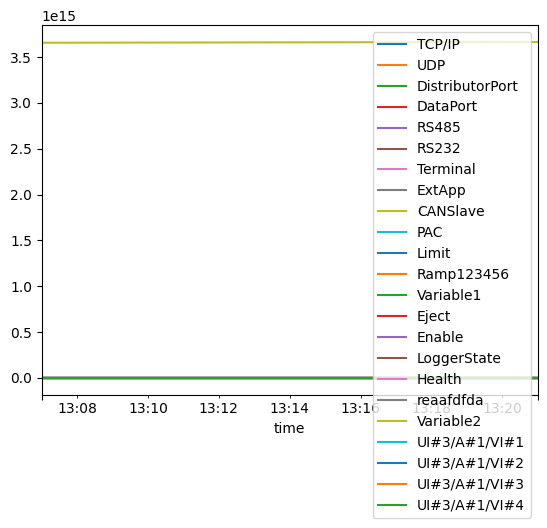

In [10]:
rename_map = {v.id: v.name for v in buf_vars}
df_buf = df_buf.rename(columns=rename_map)
df_buf.plot()

## 6) Export — CSV or UDBF
Export a window to bytes, save to disk, and preview CSV as DataFrame.

Note: Output format slightly differs when Data is exported in RAW resolution vs. aggregated (e.g., MINUTE).

Warning: Always verify the result has the size you expect! Empty results may be currently returned on exceptions!

In [14]:
src

GIStream(name='ImportTestStreamCSV2', id='11111111-2222-3333-4444-555555555514', sample_rate_hz=0.016666666666666666, first_ts=1762780020000.0, last_ts=1762780920000.0, index=1)

Export the last hour of data from the selected buffer source as a UDBF file. (File can be opened in GI.bench)

In [ ]:
from datetime import datetime, timezone

now_ms = int(datetime.now(tz=timezone.utc).timestamp() * 1000)
one_hour_ms = 60 * 60 * 1000

raw = client.export_udbf(
    selectors,
    start_ms=now_ms - one_hour_ms,
    end_ms=now_ms,
    timezone="UTC",
)

path_csv = "docs/debug_export_data_udbf.dat"
with open(path_csv, "wb") as f:
    f.write(raw)


Export data as CSV and preview as DataFrame.

In [16]:
raw = client.export_data(
    selectors,
    start_ms=src.last_ts - 1200000,
    end_ms=src.last_ts,
    format=DataFormat.CSV,
    resolution=Resolution.MINUTE,
    timezone="UTC"
)
path_csv = "debug_export_datacsv.csv"
with open(path_csv, "wb") as f:
    f.write(raw)
pd.read_csv(BytesIO(raw), sep=";", decimal=",").head()

2025-11-12 15:40:23,727 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 5679
2025-11-12 15:40:23,760 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 6868
2025-11-12 15:40:23,885 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 3585


,datetime,time,TCP/IP,UDP,DistributorPort,DataPort,RS485,RS232,Terminal,ExtApp,...,Eject,Enable,LoggerState,Health,reaafdfda,Variable2,UI#3/A#1/VI#1,UI#3/A#1/VI#2,UI#3/A#1/VI#3,UI#3/A#1/VI#4
0,NaN,NaN,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,...,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2,ImportTestStreamCSV2
1,NaN,NaN,avg,avg,avg,avg,avg,avg,avg,avg,...,avg,avg,avg,avg,avg,avg,avg,avg,avg,avg
2,NaN,[s since 01.01.1970],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,﻿2025-11-10T13:07:00,1762780020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,7809.0,0.0,3656334113243136.0,67108864.0,67108864.0,67108864.0,67108864.0
4,﻿2025-11-10T13:08:00,1762780080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,78033.0,0.0,3656934066487296.0,67108864.0,67108864.0,67108864.0,67108864.0


Export large data in parts (e.g., 10s windows) and merge into a single DataFrame.

In [ ]:
from pathlib import Path
import pandas as pd

# Since data is loaded into RAM, it makes sense to make files on larger exports
out_dir = Path("docs/debug_export_parts")
out_dir.mkdir(parents=True, exist_ok=True)

step_ms = 10_000

t1 = int(src.last_ts)
t0 = t1 - 120_000

paths = []
for start in range(t0, t1, step_ms):
    end = min(start + step_ms, t1)

    raw = client.export_data(
        selectors,
        start_ms=start,
        end_ms=end,
        format=DataFormat.CSV,
        resolution=Resolution.RAW,
        timezone="UTC",
    )

    path = out_dir / f"export_raw_{start}_{end}.csv"
    path.write_bytes(raw)
    paths.append(path)

# Merge (simple case: each chunk has a header row)
dfs = [pd.read_csv(p, sep=";", decimal=",") for p in paths]
df_all = pd.concat(dfs, ignore_index=True)


## 7) Import — CSV/UDBF into stream
Re-import the previously exported CSV into a new stream ID.

In [17]:
from gi_data.mapping.models import CSVImportSettings

new_sid = UUID("11111111-2222-3333-4444-555555555512")
with open(path_csv, "rb") as f:
    payload = f.read()

# Adapt the settings to the structure of your CSV that you want to upload
csv_settings = CSVImportSettingsDefaultCloud()  # CSVImportSettings for non cloud targets

client.import_data(str(new_sid), "PythonImportedStream", csv_settings=csv_settings, file_bytes=payload,
                   format=DataFormat.CSV, target="stream")

2025-11-12 15:41:09,438 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 208
2025-11-12 15:41:13,306 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 58
2025-11-12 15:41:16,351 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 93


'27663d74-6670-418e-baf9-f506d1739f63'

## 8) History — list measurements and fetch slice
List all measurements for a history source.

Select a measurement and fetch its variables for a time range.

Note: Your target stream must have measurements available.

In [18]:
hist_src = client.list_history_sources()[5]

measurements = client.list_history_measurements(src.id)
for meas, idx in zip(measurements, range(len(measurements))):
    logger.info(f"Measurement {idx}: {meas}")
selected_meas = measurements[0]

variables = selected_meas.vars

selectors: List[VarSelector] = [
    VarSelector(SID=selected_meas.source_id, VID=v.id)
    for v in variables
]

df_hist = client.fetch_history(
    selectors,
    measurement_id=selected_meas.id,
    start_ms=selected_meas.last_ts - 3600000,
    end_ms=selected_meas.last_ts,
)

df_hist.head()
df_hist.to_csv("debug_export_history_measurement.csv")

2025-11-12 15:43:35,183 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 6817
2025-11-12 15:43:35,296 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 158
2025-11-12 15:43:35,297 - __main__ - INFO - Measurement 0: id='d7abe97c-90fc-494d-8417-f80dac5f32aa' absolute_start=1762780020000.0 last_ts=1762780920000.0 sample_rate_hz=0.016666666666666666 source_id='11111111-2222-3333-4444-555555555514' name=None available_time_sec=None cfg_checksum=None data_storage=None index=None is_removable=None kind=None max_time_sec=None start_date=None updated=None variables=None internal_id=None
2025-11-12 15:43:35,335 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 5679
2025-11-12 15:43:35,388 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 1757
2025-11-12 15:43:35,505 - gi_data.infra.http - INFO - Response: 200 | Content-Length: 2530


## 10) Troubleshooting
- Ensure base URLs and credentials are correct.
- Check that the selected variables/streams exist and are readable.
- Prefer small windows first; increase `points` gradually.
- For notebooks, avoid long-running streams; limit iterations.
- Set log level to debug for detailed request/response info from the backend (via client.set_log_level()).